# Set up workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import cartopy

In [2]:
import cftime
import scipy

In [3]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import make_multisimulation_dataset

In [4]:
from load_ensembles import *
import quick_map

In [5]:
from load_gridcell_areas import *

# Load data

In [6]:
dir_input='/glade/work/czarakas/coupled_PPE/data/data_for_figures/EOFs/'

eofs_coupled=xr.open_dataset(dir_input+'EOFanalysis_TSKIN_coupled_EOFs.nc')
pcs_coupled=xr.open_dataset(dir_input+'EOFanalysis_TSKIN_coupled_PCs.nc')
var_explained_coupled=xr.open_dataset(dir_input+'EOFanalysis_TSKIN_coupled_varianceFraction.nc')

eofs_offline=xr.open_dataset(dir_input+'EOFanalysis_TSKIN_offline_EOFs.nc')
pcs_offline=xr.open_dataset(dir_input+'EOFanalysis_TSKIN_offline_PCs.nc')
var_explained_offline=xr.open_dataset(dir_input+'EOFanalysis_TSKIN_offline_varianceFraction.nc')

In [7]:
dir_input='/glade/work/czarakas/coupled_PPE/data/data_for_figures/annual_means/'

pvals_coupled=xr.open_dataset(dir_input+'pval_TSKIN_Annual_mean_coupled.nc')#['pval']
ds_array_coupled=xr.open_dataset(dir_input+'TSKIN_Annual_mean_coupled.nc')
ds_ref_coupled=xr.open_dataset(dir_input+'ref_TSKIN_Annual_mean_coupled.nc')#['calculated_PREC_FROM_ATM']

pvals_offline=xr.open_dataset(dir_input+'pval_TSKIN_Annual_mean_offline.nc')#['pval']
ds_array_offline=xr.open_dataset(dir_input+'TSKIN_Annual_mean_offline.nc')
ds_ref_offline=xr.open_dataset(dir_input+'ref_TSKIN_Annual_mean_offline.nc')#['calculated_PREC_FROM_ATM']

In [8]:
dir_input='/glade/work/czarakas/coupled_PPE/data/data_for_figures/response_to_CO2/'
ds_array_2xCO2=xr.open_dataset(dir_input+'Reponse_2xCO2_AnnualMean_Full.nc')

# Make figures

In [9]:
def make_map(mapdata,
            cmap=plt.cm.get_cmap("RdBu_r",11), vlims=[-2,2],
             fname=None, sigmask=None
            ):
    plt.rcParams.update({'font.size': 25})
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_global()

    cyclic_data, cyclic_lons = add_cyclic_point(mapdata, coord=mapdata.lon)

    plt.pcolormesh(cyclic_lons, mapdata.lat, #contourf
                       cyclic_data, 
                       cmap=cmap, vmin=vlims[0], vmax=vlims[1],#levels=np.arange(-100,100),
                       transform=ccrs.PlateCarree())#, extend='both')
    plt.colorbar(extend='both', orientation='horizontal')#, ticks=np.arange(-0.025, 0.030, 0.005))

    if sigmask is not None:
        cyclic_data_mask, cyclic_lons_mask = add_cyclic_point(sigmask, coord=sigmask.lon)
        ax.contourf(
                    cyclic_lons_mask, sigmask.lat, cyclic_data_mask,
                    transform=ccrs.PlateCarree(),
                    colors='none',
                    levels=[0.5, 1.5],
                    hatches=['...'])

    plt.tight_layout()
    ax.add_feature(cartopy.feature.OCEAN, facecolor='white', zorder=1)
    ax.coastlines()
    if fname is not None:
        plt.savefig(fname)#'Range_pct_change.png') #'Figures/Range_pct_change.eps'

### Figure 2a

In [10]:
mod_factor=2*np.std(pcs_coupled.pcs[:,0])

In [11]:
#leadingEOF_coupled=-eofs_coupled.eofs[:,:,0]
#warming_factor_leadingEOF_1degreeglobal=1/leadingEOF_coupled.mean(dim=['lat','lon'])
#mapdata=leadingEOF_coupled*warming_factor_leadingEOF_1degreeglobal/landweights

In [12]:
leadingEOF_coupled=-eofs_coupled.eofs[:,:,0]*mod_factor/landweights
global_delta_Ts_land=np.abs((leadingEOF_coupled*landweights).mean(dim=['lat','lon']))
mapdata=leadingEOF_coupled

In [13]:
sigmask=((pvals_coupled.pval>0.05).sum(dim=['ensemble_key'])>=31)

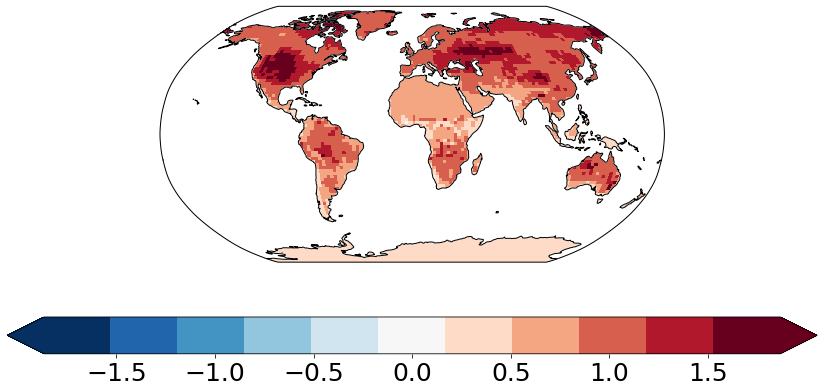

In [15]:
make_map(mapdata, sigmask=sigmask,
        vlims=[-2*global_delta_Ts_land,2*global_delta_Ts_land],
        fname='Figure2a.png')

### Figure 2b

In [16]:
mod_factor=2*np.std(pcs_offline.pcs[:,0])

In [17]:
leadingEOF_offline=-eofs_offline.eofs[:,:,0]*mod_factor/landweights
global_delta_Ts_land=np.abs(leadingEOF_offline*landweights).mean(dim=['lat','lon'])
mapdata=leadingEOF_offline

In [18]:
#warming_factor_leadingEOF_1degreeglobal=1/leadingEOF_offline.mean(dim=['lat','lon'])
#mapdata=leadingEOF_offline*warming_factor_leadingEOF_1degreeglobal/landweights

In [19]:
sigmask=((pvals_offline.pval>0.05).sum(dim=['ensemble_key'])>=31)

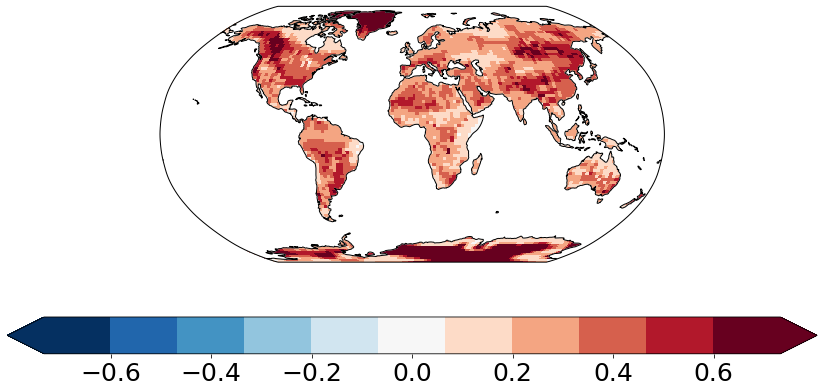

In [20]:
make_map(mapdata, sigmask=None,
        vlims=[-2*global_delta_Ts_land,2*global_delta_Ts_land],
        fname='Figure2b.png')

### Figure 2c

In [21]:
mapdata=ds_array_2xCO2['TS']

In [22]:
global_delta_Ts_land=(mapdata*landweights).mean(dim=['lat','lon'])#*0.9

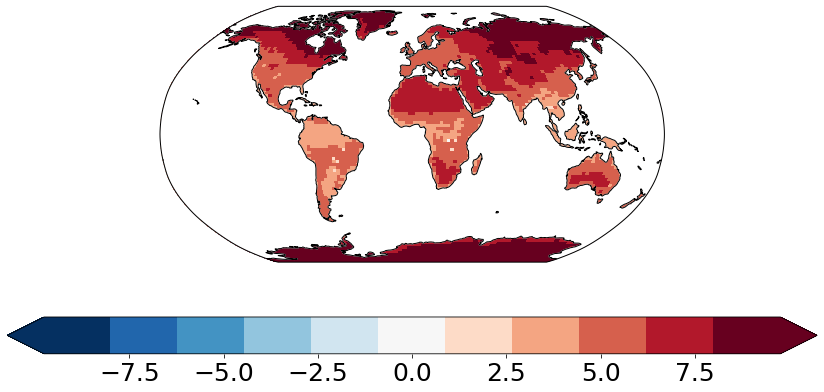

In [26]:
make_map(mapdata, 
         cmap=plt.cm.get_cmap("RdBu_r",11), 
         vlims=[-1.5*global_delta_Ts_land,1.5*global_delta_Ts_land],
        fname='Figure2c.png')